<a href="https://colab.research.google.com/github/silviolima07/autoencoders/blob/main/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

In [ ]:
# Este dataset traz dados o registro do sinal ecg obtido em exames de eletrocardiograma. Este exame avalia o batimento cardiaco e pode detectar anomalias no coração.

In [ ]:
df_ecg = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header = None)

In [ ]:
df_ecg.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [ ]:
%matplotlib inline
sns.set(style='whitegrid')
 
#Read data and do some preprocessing
df = pd.read_csv("creditcard.csv")
 
#Time does not help. Delete it
df = df.drop(['Time'], axis=1)
 
#Scale Amount only. All other variables are PCA components
df['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))
 
#Split in train and test (train contains only 'normal' transactions)
df_fraud = df[df['Class']==1]
df_normal = df[df['Class']==0]
df_normal = df_normal.sample(frac = 1.0).reset_index(drop = True) #Just shuffling
df_normal_1 = df_normal.iloc[:int(df_normal.shape[0]*0.8),:] #80% of normal data for training
df_normal_2 = df_normal.iloc[int(df_normal.shape[0]*0.8):,:] #20% of normal data to merge with fraudulent (test set)
 
X_test = pd.concat([df_fraud,df_normal_2], axis = 0)
X_test = X_test.sample(frac = 1.0).reset_index(drop = True) #Just shuffling
 
#Separate in input and target variables
X_train = df_normal_1[df_normal_1['Class'] == 0]
X_train = X_train.drop(['Class'], axis=1)
 
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

In [ ]:
df_normal.shape

(3970, 30)

In [ ]:
df_normal.iloc[0,:]

V1       -0.349248
V2        0.503362
V3        0.503871
V4       -2.509402
V5        0.988556
V6        0.044428
V7        0.895082
V8       -0.012519
V9        0.817473
V10      -0.993112
V11       0.189010
V12       0.008204
V13      -1.100593
V14       0.425618
V15       0.646140
V16      -0.232741
V17      -0.978951
V18       0.657313
V19       0.349225
V20      -0.011709
V21       0.038657
V22       0.447801
V23      -0.434843
V24      -1.364113
V25       0.117276
V26      -0.739460
V27       0.243098
V28      -0.043248
Amount   -0.299540
Class     0.000000
Name: 0, dtype: float64

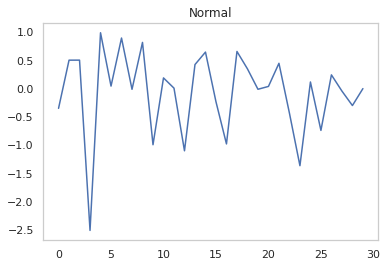

In [ ]:
plt.plot(np.arange(30),df_normal.iloc[0,:])
plt.grid()
plt.title("Normal")
plt.show()

In [ ]:
df_fraud.iloc[0,:]

V1       -2.312227
V2        1.951992
V3       -1.609851
V4        3.997906
V5       -0.522188
V6       -1.426545
V7       -2.537387
V8        1.391657
V9       -2.770089
V10      -2.772272
V11       3.202033
V12      -2.899907
V13      -0.595222
V14      -4.289254
V15       0.389724
V16      -1.140747
V17      -2.830056
V18      -0.016822
V19       0.416956
V20       0.126911
V21       0.517232
V22      -0.035049
V23      -0.465211
V24       0.320198
V25       0.044519
V26       0.177840
V27       0.261145
V28      -0.143276
Amount   -0.304220
Class     1.000000
Name: 541, dtype: float64

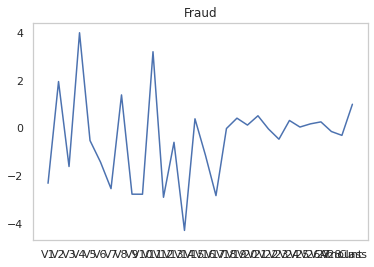

In [ ]:
plt.plot(df_fraud.iloc[0,:])
plt.grid()
plt.title("Fraud")
plt.show()

In [ ]:
#Build the Neural Network
input_dim = X_train.shape[1]
 
model = Sequential()
model.add(Dense(29,input_dim = input_dim, activation="relu"))
model.add(Dense(14, activation="relu"))
model.add(Dense(7, activation="relu"))
model.add(Dense(14, activation="relu"))
model.add(Dense(input_dim, activation="sigmoid"))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
 
#Check the architecture of the autoencoder
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 29)                870       
                                                                 
 dense_1 (Dense)             (None, 14)                420       
                                                                 
 dense_2 (Dense)             (None, 7)                 105       
                                                                 
 dense_3 (Dense)             (None, 14)                112       
                                                                 
 dense_4 (Dense)             (None, 29)                435       
                                                                 
Total params: 1,942
Trainable params: 1,942
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
100/100 [==============================] - 1s 5ms/step - loss: 1.0134 - accuracy: 0.1527 - val_loss: 0.8194 - val_accuracy: 0.2550
Epoch 2/100
100/100 [==============================] - 0s 3ms/step - loss: 0.8257 - accuracy: 0.2390 - val_loss: 0.7335 - val_accuracy: 0.2977
Epoch 3/100
100/100 [==============================] - 0s 2ms/step - loss: 0.7883 - accuracy: 0.3366 - val_loss: 0.7102 - val_accuracy: 0.3781
Epoch 4/100
100/100 [==============================] - 0s 3ms/step - loss: 0.7598 - accuracy: 0.3778 - val_loss: 0.6808 - val_accuracy: 0.4133
Epoch 5/100
100/100 [==============================] - 0s 3ms/step - loss: 0.7354 - accuracy: 0.4096 - val_loss: 0.6638 - val_accuracy: 0.4083
Epoch 6/100
100/100 [==============================] - 1s 6ms/step - loss: 0.7234 - accuracy: 0.4219 - val_loss: 0.6555 - val_accuracy: 0.4196
Epoch 7/100
100/100 [==============================] - 1s 7ms/step - loss: 0.7158 - accuracy: 0.4348 - val_loss: 0.6495 - val_accuracy: 0.4472

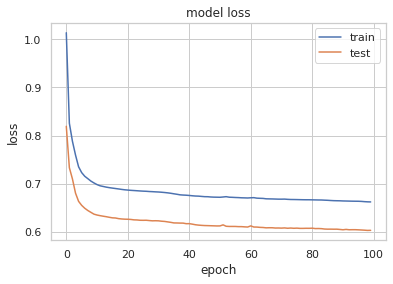

In [ ]:
#Fit the autoencoder and check loss for train and test
checkpointer = ModelCheckpoint(filepath="nae.h5", verbose=0, save_best_only=True)
 
#Save history to plot learning curves
history = model.fit(X_train, X_train,
epochs=100,
batch_size=32,
shuffle=True,
validation_data=(X_test, X_test),
verbose=1,
callbacks=[checkpointer]).history
 
autoencoder = load_model('nae.h5')
 
#Plot losses
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

[Text(0, 0.5, 'Normal'), Text(0, 1.5, 'Fraud')]

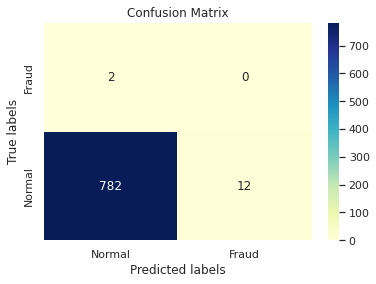

In [ ]:
#Predict on test set
predictions = model.predict(X_test)
 
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'mse': mse,
'fraud': y_test})
 
#Set an error threshold above which a transaction is considered fraud
threshold = 4.5
error_df['pred_01'] = [1 if e > threshold else 0 for e in error_df['mse'].values]
conf_mat = confusion_matrix(error_df['fraud'], error_df['pred_01'])
 
#Print confusion matrix for the given threshold
ax= plt.subplot()
sns.heatmap(conf_mat, annot=True, fmt="g", cmap="YlGnBu")
 
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.set_ylim([0,2])
ax.xaxis.set_ticklabels(["Normal", "Fraud"]); ax.yaxis.set_ticklabels(["Normal", "Fraud"])


In [ ]:
dados = df_ecg.iloc[:,:-1].values # Pega os dados em cada linha até a penultima coluna, na forma de array.
labels = df_ecg.iloc[:,-1].values

In [ ]:
labels

array([1., 1., 1., ..., 0., 0., 0.])

In [ ]:
dados_treino, dados_teste, labels_treino, labels_teste = train_test_split(dados, labels, test_size = 0.2, random_state = 2)

In [ ]:
min = tf.reduce_min(dados_treino)
max = tf.reduce_max(dados_treino)

In [ ]:
dados_treino = (dados_treino - min)/(max - min)
dados_teste = (dados_teste - min) / (max - min)

In [ ]:
dados_treino

<tf.Tensor: shape=(3998, 140), dtype=float64, numpy=
array([[0.63417299, 0.60144   , 0.56492947, ..., 0.24180697, 0.27333807,
        0.419205  ],
       [0.68348344, 0.53079511, 0.30631429, ..., 0.65009293, 0.68153161,
        0.58446075],
       [0.44795084, 0.37356573, 0.3282699 , ..., 0.41549221, 0.38023082,
        0.35814732],
       ...,
       [0.51207502, 0.39628231, 0.33170974, ..., 0.72241414, 0.75635135,
        0.70404592],
       [0.64585082, 0.56747889, 0.50753806, ..., 0.43371981, 0.50302426,
        0.6156047 ],
       [0.51127771, 0.40041333, 0.37825678, ..., 0.44149792, 0.40077225,
        0.26994847]])>

In [ ]:
dados_teste

<tf.Tensor: shape=(1000, 140), dtype=float64, numpy=
array([[0.52194023, 0.3083143 , 0.23954641, ..., 0.57696192, 0.55615623,
        0.36177862],
       [0.55687724, 0.37153055, 0.28143267, ..., 0.71556205, 0.76727773,
        0.65777286],
       [0.6021764 , 0.49890084, 0.41482644, ..., 0.28668782, 0.34099053,
        0.4753087 ],
       ...,
       [0.50556871, 0.24759823, 0.21199272, ..., 0.58121641, 0.64595942,
        0.4404814 ],
       [0.63274986, 0.46455687, 0.37414149, ..., 0.7099325 , 0.76516728,
        0.75502305],
       [0.47509136, 0.43522402, 0.45753122, ..., 0.3022578 , 0.33032062,
        0.48580499]])>

In [ ]:
dados_treino = tf.cast(dados_treino, dtype = tf.float32)
dados_teste = tf.cast(dados_teste, dtype = tf.float32)

In [ ]:
dados_treino

<tf.Tensor: shape=(3998, 140), dtype=float32, numpy=
array([[0.634173  , 0.60144   , 0.5649295 , ..., 0.24180697, 0.27333808,
        0.419205  ],
       [0.6834834 , 0.5307951 , 0.3063143 , ..., 0.65009296, 0.6815316 ,
        0.58446074],
       [0.44795084, 0.37356573, 0.3282699 , ..., 0.4154922 , 0.3802308 ,
        0.35814732],
       ...,
       [0.512075  , 0.39628232, 0.33170974, ..., 0.72241414, 0.75635135,
        0.7040459 ],
       [0.64585084, 0.5674789 , 0.5075381 , ..., 0.4337198 , 0.5030243 ,
        0.6156047 ],
       [0.51127774, 0.40041333, 0.37825677, ..., 0.44149792, 0.40077224,
        0.26994848]], dtype=float32)>

In [ ]:
labels_treino = labels_treino.astype(bool)
labels_teste = labels_teste.astype(bool)

In [ ]:
dados_treino_normal = dados_treino[labels_treino]
dados_teste_normal = dados_teste[labels_teste]

In [ ]:
dados_treino_normal

<tf.Tensor: shape=(2321, 140), dtype=float32, numpy=
array([[0.6834834 , 0.5307951 , 0.3063143 , ..., 0.65009296, 0.6815316 ,
        0.58446074],
       [0.44795084, 0.37356573, 0.3282699 , ..., 0.4154922 , 0.3802308 ,
        0.35814732],
       [0.4871815 , 0.31543225, 0.2647011 , ..., 0.63705486, 0.5587706 ,
        0.3526786 ],
       ...,
       [0.4407831 , 0.25385043, 0.23685683, ..., 0.59369457, 0.4590975 ,
        0.23203413],
       [0.512075  , 0.39628232, 0.33170974, ..., 0.72241414, 0.75635135,
        0.7040459 ],
       [0.51127774, 0.40041333, 0.37825677, ..., 0.44149792, 0.40077224,
        0.26994848]], dtype=float32)>

In [ ]:
dados_treino_anormal = dados_treino[~labels_treino]
dados_teste_anormal = dados_teste[~labels_teste]

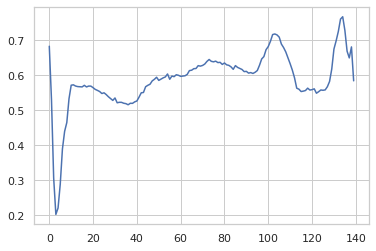

In [ ]:
plt.plot(np.arange(140), dados_treino_normal[0])

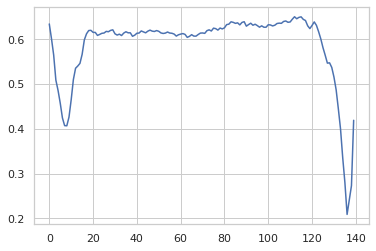

In [ ]:
plt.plot(np.arange(140), dados_treino_anormal[0])

In [ ]:
#Build the Neural Network
input_dim = dados_treino_normal.shape[1]
 
model = Sequential()
model.add(Dense(32,input_dim = input_dim, activation="relu"))
model.add(Dense(16, activation="relu"))
model.add(Dense(8, activation="relu"))
model.add(Dense(16, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(input_dim, activation="sigmoid"))
model.compile(optimizer='adam', loss='mae')
 
#Check the architecture of the autoencoder
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 32)                4512      
                                                                 
 dense_6 (Dense)             (None, 16)                528       
                                                                 
 dense_7 (Dense)             (None, 8)                 136       
                                                                 
 dense_8 (Dense)             (None, 16)                144       
                                                                 
 dense_9 (Dense)             (None, 32)                544       
                                                                 
 dense_10 (Dense)            (None, 140)               4620      
                                                                 
Total params: 10,484
Trainable params: 10,484
Non-trai

Epoch 1/30
5/5 [==============================] - 1s 48ms/step - loss: 0.1069 - val_loss: 0.1042
Epoch 2/30
5/5 [==============================] - 0s 18ms/step - loss: 0.1035 - val_loss: 0.1022
Epoch 3/30
5/5 [==============================] - 0s 15ms/step - loss: 0.1011 - val_loss: 0.0984
Epoch 4/30
5/5 [==============================] - 0s 17ms/step - loss: 0.0961 - val_loss: 0.0911
Epoch 5/30
5/5 [==============================] - 0s 16ms/step - loss: 0.0872 - val_loss: 0.0795
Epoch 6/30
5/5 [==============================] - 0s 15ms/step - loss: 0.0747 - val_loss: 0.0663
Epoch 7/30
5/5 [==============================] - 0s 16ms/step - loss: 0.0628 - val_loss: 0.0578
Epoch 8/30
5/5 [==============================] - 0s 16ms/step - loss: 0.0546 - val_loss: 0.0480
Epoch 9/30
5/5 [==============================] - 0s 15ms/step - loss: 0.0446 - val_loss: 0.0401
Epoch 10/30
5/5 [==============================] - 0s 16ms/step - loss: 0.0378 - val_loss: 0.0344
Epoch 11/30
5/5 [============

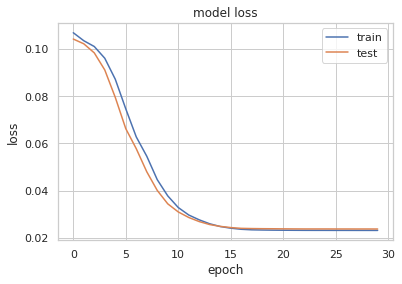

In [ ]:
#Fit the autoencoder and check loss for train and test
checkpointer = ModelCheckpoint(filepath="nae.h5", verbose=0, save_best_only=True)
 
#Save history to plot learning curves
history = model.fit(dados_treino_normal, dados_treino_normal,
epochs=30,
batch_size=512,
shuffle=True,
validation_data=(dados_teste_normal, dados_teste_normal),
verbose=1,
callbacks=[checkpointer]).history
 
autoencoder = load_model('nae.h5')
 
#Plot losses
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

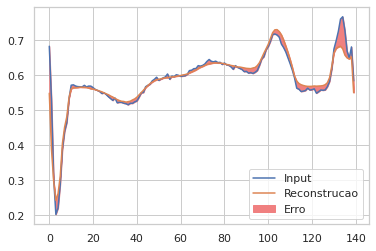

In [ ]:
dados_normal = dados_treino_normal[0]
dados_recons = model.predict(dados_treino_normal)[0]
plt.plot(np.arange(140), dados_normal)
plt.plot(np.arange(140), dados_recons)
plt.fill_between(np.arange(140),dados_normal, dados_recons, color='lightcoral')
plt.legend(labels=['Input', 'Reconstrucao', 'Erro'])
plt.show()

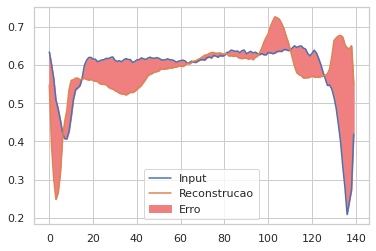

In [ ]:
dados_anormal = dados_treino_anormal[0]
dados_recons = model.predict(dados_treino_anormal)[0]
plt.plot(np.arange(140), dados_anormal)
plt.plot(np.arange(140), dados_recons)
plt.fill_between(np.arange(140),dados_anormal, dados_recons, color='lightcoral')
plt.legend(labels=['Input', 'Reconstrucao', 'Erro'])
plt.show()

In [ ]:
import numpy 
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.datasets import mnist

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
X_train.shape

(60000, 28, 28)

In [ ]:
X_test.shape

(10000, 28, 28)

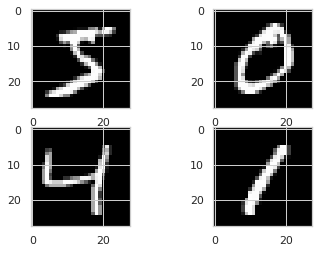

In [ ]:

plt.subplot(221)
plt.imshow(X_train[0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(X_train[1], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(X_train[2], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(X_train[3], cmap=plt.get_cmap('gray'))
# show the plot
plt.show()


In [ ]:
num_pixels = X_train.shape[1] * X_train.shape[2]
X_train = X_train.reshape(X_train.shape[0], num_pixels).astype('float32')
X_test = X_test.reshape(X_test.shape[0], num_pixels).astype('float32')
X_train = X_train / 255
X_test = X_test / 255

In [ ]:
X_train.shape

(60000, 784)

In [ ]:
X_test.shape

(10000, 784)

In [ ]:
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
noise_factor = 0.2
x_train_noisy = X_train + noise_factor * numpy.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
x_test_noisy = X_test + noise_factor * numpy.random.normal(loc=0.0, scale=1.0, size=X_test.shape)
x_train_noisy = numpy.clip(x_train_noisy, 0., 1.)
x_test_noisy = numpy.clip(x_test_noisy, 0., 1.)

In [ ]:
x_train_noisy.shape

(60000, 784)

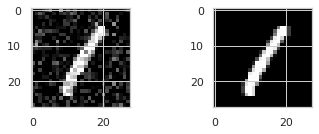

In [ ]:

noisy = numpy.reshape(x_train_noisy, (60000,28,28)) *255
plt.subplot(221)
plt.imshow(noisy[3], cmap=plt.get_cmap('gray'))
plt.subplot(222)
normal = numpy.reshape(X_train, (60000,28,28)) *255
plt.imshow(normal[3], cmap=plt.get_cmap('gray'))
# show the plot
plt.show()

In [ ]:
# create model
model = Sequential()
model.add(Dense(500, input_dim=num_pixels, activation='relu'))
model.add(Dense(300, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(300, activation='relu'))
model.add(Dense(500, activation='relu'))
model.add(Dense(784, activation='sigmoid'))

In [ ]:
# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
# Training model
model.fit(x_train_noisy, # training data
          X_train,       # labels / target
          validation_data=(x_test_noisy, X_test), 
          epochs=2,
          batch_size=200)

Epoch 1/2
300/300 [==============================] - 10s 31ms/step - loss: 0.0420 - val_loss: 0.0198
Epoch 2/2
300/300 [==============================] - 9s 31ms/step - loss: 0.0167 - val_loss: 0.0141


In [ ]:
# Final evaluation of the model
pred = model.predict(x_test_noisy)

In [ ]:
pred.shape

(10000, 784)

In [ ]:
X_test.shape

(10000, 784)

Test Images


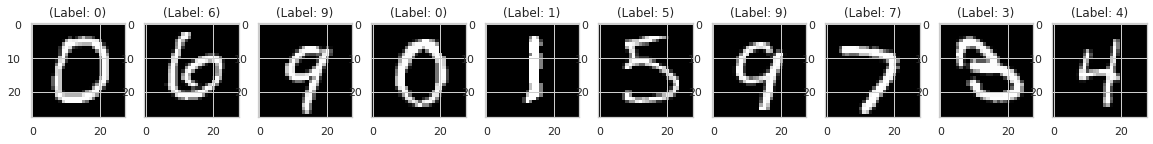

Test Images with Noise


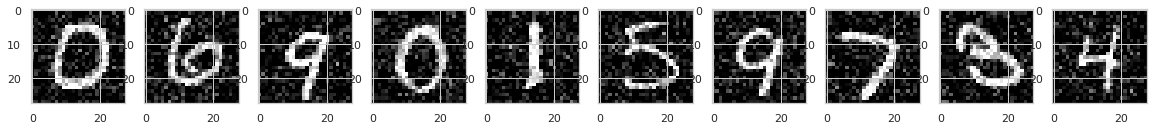

Reconstruction of Noisy Test Images


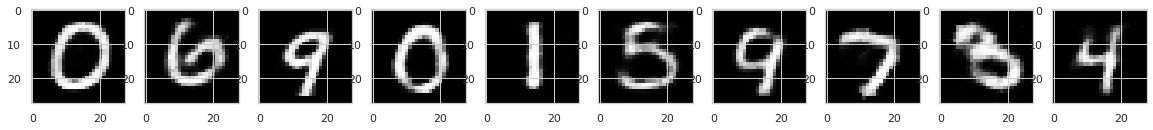

In [ ]:
X_test = numpy.reshape(X_test, (10000,28,28)) *255
pred = numpy.reshape(pred, (10000,28,28)) *255
x_test_noisy = numpy.reshape(x_test_noisy, (-1,28,28)) *255
plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(X_test[i,:,:], cmap='gray')
    curr_lbl = y_test[i]
    plt.title("(Label: " + str(curr_lbl) + ")")
plt.show()    
plt.figure(figsize=(20, 4))
print("Test Images with Noise")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(x_test_noisy[i,:,:], cmap='gray')
plt.show()    
plt.figure(figsize=(20, 4))
print("Reconstruction of Noisy Test Images")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(pred[i,:,:], cmap='gray')  
plt.show()

In [ ]:
#Fit the autoencoder and check loss for train and test
checkpointer = ModelCheckpoint(filepath="nae.h5", verbose=0, save_best_only=True)
 
#Save history to plot learning curves
history = model.fit(x_train_noisy, 
                    X_train,
                    epochs=30,
                    batch_size=512,
                    shuffle=True,
                    validation_data=(x_test_noisy, X_test),
                    verbose=1,
                    callbacks=[checkpointer]).history

 
autoencoder = load_model('nae.h5')
 
#Plot losses
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

Epoch 1/30
117/118 [============================>.] - ETA: 0s - loss: 0.0129

ValueError: ignored